In [6]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

def create_paired_dataset(input_file, output_file=None, label=None):
    # Load the original matrix
    x = np.load(input_file)
    if label == 0:
        y = np.zeros(x.shape[0], dtype=int)
    elif label == 1:
        y = np.ones(x.shape[0], dtype=int)
    
    # Create the paired dataset
    paired_dataset = (x, y)
    
    # Optionally save the paired dataset
    if output_file:
        np.save(output_file, paired_dataset)
    
    return paired_dataset

## Load datasets

In [7]:
cautious_x, cautious_y = create_paired_dataset("../activations/deepseek_layer_18_cautious_activations.npy", label=1)
non_cautious_x, non_cautious_y = create_paired_dataset("../activations/deepseek_layer_18_noncautious_activations.npy", label=0)


## Create train-test sets for logistic classfier

In [8]:
X = np.vstack((cautious_x, non_cautious_x))
y = np.concatenate((cautious_y, non_cautious_y))

# Create a permutation of indices
shuffle_indices = np.random.permutation(len(y))
# Use these indices to shuffle both X and y in the same way
X = X[shuffle_indices]
y = y[shuffle_indices]

print(X)
print(y)

# 5. Split into train and test sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Feature vector size: {X_train.shape[1]} dimensions")
print(f"Class distribution in training: {np.bincount(y_train)}")
print(f"Class distribution in testing: {np.bincount(y_test)}")

[[-0.02460765 -0.00309617  0.09083491 ...  0.04488679 -0.06912014
   0.09099901]
 [-0.08197411 -0.01136535  0.05260378 ...  0.0786916  -0.12165424
   0.04413205]
 [-0.08120751 -0.04779399  0.10160149 ...  0.02376623 -0.05843361
  -0.02293561]
 ...
 [-0.08644383 -0.02932145  0.0767254  ...  0.07033364 -0.11594739
   0.07434355]
 [-0.01807689 -0.03242161  0.09141716 ...  0.06388632 -0.05992584
   0.04043206]
 [-0.02730449 -0.02133241  0.0552378  ...  0.0156233  -0.08696614
   0.04734747]]
[1 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1
 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 0
 1 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 1
 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1 1 0 0 1 1
 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 0 1 0 0 0 1 0 0
 1 1 1 0 0]
Training set size: 142 samples
Test set size: 48 samples
Feature vector size: 4096 dimensions
Class distribution in train

## Train a logistic classfier


Accuracy: 0.9792

Classification Report:
              precision    recall  f1-score   support

Non-Cautious       0.96      1.00      0.98        24
    Cautious       1.00      0.96      0.98        24

    accuracy                           0.98        48
   macro avg       0.98      0.98      0.98        48
weighted avg       0.98      0.98      0.98        48



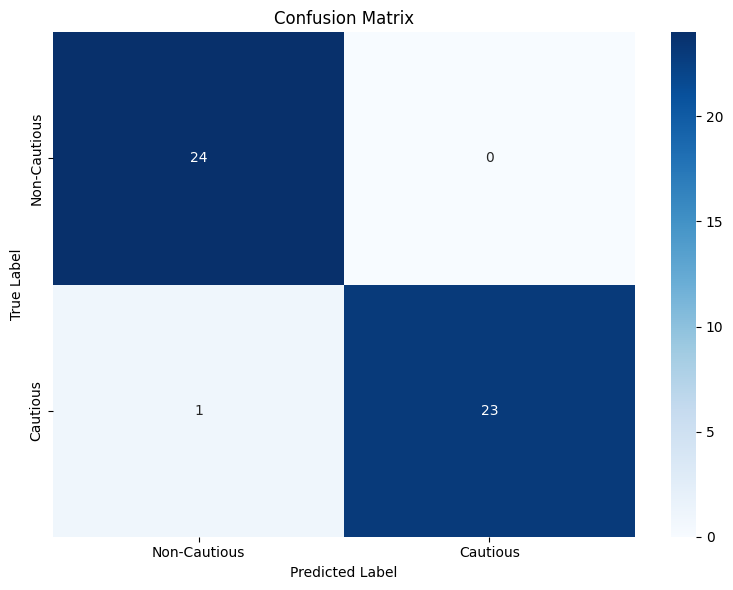


Top 10 most important features (by coefficient magnitude):
Rank 1: Feature 761 (Coefficient: 0.6087)
Rank 2: Feature 1189 (Coefficient: 0.5041)
Rank 3: Feature 1298 (Coefficient: 0.4804)
Rank 4: Feature 2082 (Coefficient: 0.4727)
Rank 5: Feature 1805 (Coefficient: 0.4592)
Rank 6: Feature 866 (Coefficient: -0.4345)
Rank 7: Feature 912 (Coefficient: -0.4267)
Rank 8: Feature 3585 (Coefficient: -0.4094)
Rank 9: Feature 4055 (Coefficient: 0.3982)
Rank 10: Feature 325 (Coefficient: -0.3435)


In [9]:
# Train a logistic regression classifier
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-Cautious", "Cautious"]))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Non-Cautious", "Cautious"],
            yticklabels=["Non-Cautious", "Cautious"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("../figures/confusion_matrix.png")
plt.show()

#  Feature importance analysis
if X_train.shape[1] < 20:  # Only show importance if we have few features
    importance = np.abs(clf.coef_[0])
    feature_names = [f"Feature {i}" for i in range(X_train.shape[1])]
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    features_df = pd.DataFrame({'feature_names': feature_names, 'importance': importance})
    features_df = features_df.sort_values('importance', ascending=False)
    
    sns.barplot(x='importance', y='feature_names', data=features_df[:10])  # Top 10 features
    plt.title('Top 10 Feature Importance for Cautious vs Non-Cautious Classification')
    plt.tight_layout()
    plt.savefig("../figures/feature_importance.png")
    plt.show()
else:
    # If too many features, just print top 10 most important
    importance = np.abs(clf.coef_[0])
    top_indices = importance.argsort()[-10:][::-1]
    print("\nTop 10 most important features (by coefficient magnitude):")
    for i, idx in enumerate(top_indices):
        print(f"Rank {i+1}: Feature {idx} (Coefficient: {clf.coef_[0][idx]:.4f})")


## Optional

In [10]:
# Save the trained model (optional)
import joblib
joblib.dump(clf, 'cautious_classifier.pkl')
print("\nModel saved as 'cautious_classifier.pkl'")




Model saved as 'cautious_classifier.pkl'
